# MNIST notebook

## import libraries

In [15]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

import logging

# Suppress TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)

## Import the dataset

In [16]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Constants
SOI_PATH = '/home/HardDisk/yared/spectrogram-dataset/soi'
CWI_PATH = '/home/HardDisk/yared/spectrogram-dataset/cwi'
IMAGE_SIZE = (128, 128)

# Preprocessing and resizing function
def preprocess_image(img_path, image_size=IMAGE_SIZE):
    img = Image.open(img_path)
    img = img.convert('L')  # Convert to grayscale
    img = img.resize(image_size)
    img_array = np.array(img)  # Convert to numpy array
    img_array = img_array.astype(np.float32)  # Convert to float32 for better precision
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img_array = preprocess_image(img_path)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Load images and labels
soi_images, soi_labels = load_images(SOI_PATH, 0)
cwi_images, cwi_labels = load_images(CWI_PATH, 1)

# Combine images and labels
X = np.array(soi_images + cwi_images)
y = np.array(soi_labels + cwi_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Example output shapes
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


Training data shape: (6532, 128, 128), Training labels shape: (6532,)
Testing data shape: (1634, 128, 128), Testing labels shape: (1634,)


In [17]:
# # # Load MNIST dataset
# test_size = 1024
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# x_train, y_train = (x_train [:4096], y_train[:4096])
# x_val, y_val = (x_test[:test_size], y_test[:test_size])
# x_test, y_test = (x_test[test_size: 2 *test_size], y_test[test_size: 2 *test_size])

# # Rescale the images
# x_train = x_train / 255.0
# x_test = x_test / 255.0
# x_val = x_val / 255.0

In [18]:
x_train = X_train
x_test = X_test

In [19]:
# # Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images = np.expand_dims(x_train, -1)
validation_images = np.expand_dims(x_test, -1)
test_images = np.expand_dims(x_test, -1)

# Convert the labels to one-hot encoded vectors
# train_labels = to_categorical(y_train, 10)
# validation_labels = to_categorical(y_test, 10)
# test_labels = to_categorical(y_test, 10)
train_labels = np.expand_dims(y_train, -1)
validation_labels = np.expand_dims(y_test, -1)
test_labels = np.expand_dims(y_test, -1)

In [20]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

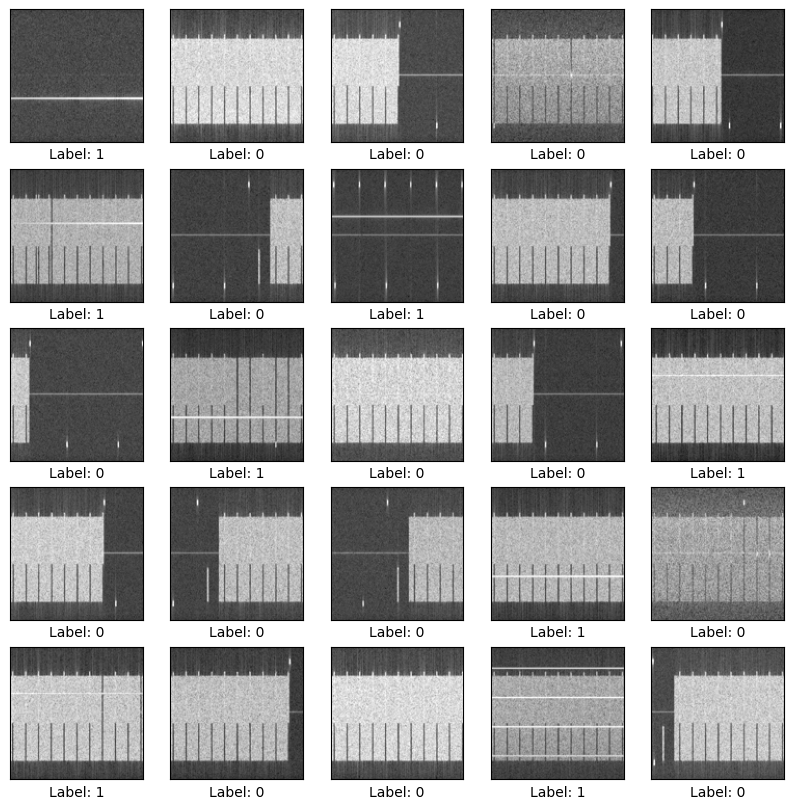

In [21]:
#Plot some of the images with their labels
plot_images(x_train, y_train, num_images=25, figsize=(10,10))

## Common Transformer components

In [22]:
class PatchExtractor(Layer):
    def __init__(self, patch_size=7):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size  # Initialize patch size

    def call(self, images):
        # Use tf.shape to get dynamic shapes as tensors
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Get dynamic shapes
        patches_shape = tf.shape(patches)
        batch_size = patches_shape[0]
        num_patches = patches_shape[1] * patches_shape[2]
        patch_dim = patches_shape[3]
        # Reshape patches using dynamic shapes
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dim])
        return patches

In [23]:
image = train_images[0]  # Select the first image of the dataset
batch = tf.expand_dims(image, 0)  # Adds the batch dimension

# Now use PatchExtractor
patches = PatchExtractor(patch_size=7)(batch)

patches.shape

TensorShape([1, 324, 49])

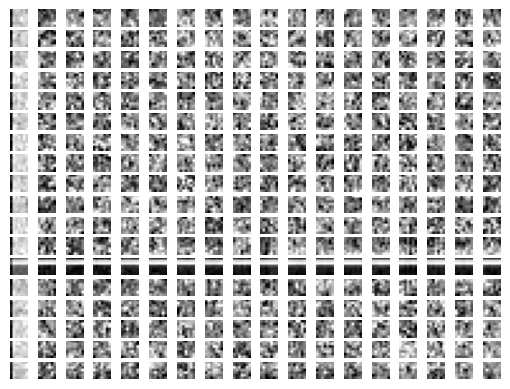

In [24]:
# Calculate the number of patches per side (sqrt) to organize the subplot grid
n = int(np.sqrt(patches.shape[1]))

# Visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Since the patch is flattened, we reshape it back to its original size, and there's only one channel for grayscale
    patch_img = tf.reshape(patch, (7, 7))
    ax.imshow(patch_img.numpy(), cmap='gray')
    ax.axis("off")

plt.show()

In [25]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=324, projection_dim=6):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches  # Total number of patches
        self.projection_dim = projection_dim  # Dimension to project each patch onto
        # Initialize weights for the class token
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(initial_value=w_init(shape=(1, projection_dim), dtype="float32"), trainable=True)
        self.projection = Dense(units=projection_dim)  # Dense layer to project patch features
        self.position_embedding = Embedding(input_dim=num_patches + 1, output_dim=projection_dim)  # Positional embeddings

    def call(self, patches):
        # batch_size = tf.shape(patches)[0]  # Calculate the batch size
        batch_size = tf.shape(patches)[0]
        # Repeat the class token for each item in the batch
        class_token = tf.tile(self.class_token, multiples=[batch_size, 1])
        class_token = tf.reshape(class_token, (batch_size, 1, self.projection_dim))
        # Project the patches to the specified dimension
        patches_embed = self.projection(patches)
        # Concatenate the class token with the projected patches
        patches_embed = tf.concat([class_token, patches_embed], axis=1)
        # Calculate positional embeddings for all patches + class token
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positional embeddings to the concatenated embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [26]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 325, 6])

In [27]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        # First dense layer with GELU activation
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        # Second dense layer for output features
        self.dense2 = Dense(out_features)
        # Dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Apply first dense layer
        x = self.dense1(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply second dense layer
        x = self.dense2(x)
        # Apply dropout again
        y = self.dropout(x)
        return y

mlp = MLP(64, 16)
y = mlp(tf.zeros((1, 325, 6)))
y.shape

TensorShape([1, 325, 16])

## Common Quantum functions

In [28]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"

In [29]:
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas

In [30]:
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])

In [31]:
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

## Classical transformer

In [32]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=1, dropout_rate=0.1):
        super(Block, self).__init__()
        # First layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-6)
        # Multi-head attention layer
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        # Second layer normalization
        self.norm2 = LayerNormalization(epsilon=1e-6)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply multi-head attention
        attention_output = self.attn(x1, x1)
        # Add residual connection after attention
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection after MLP
        y = Add()([x3, x2])
        return y

block = Block(6)
y = block(tf.zeros((1, 325, 6)))
y.shape

TensorShape([1, 325, 6])

In [33]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=1, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

transformer = TransformerEncoder(6)
y = transformer(embeddings)
y.shape

TensorShape([1, 325, 6])

In [34]:
def create_VisionTransformer(num_classes, num_patches=324, projection_dim=6, input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='softmax')(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model
model = create_VisionTransformer(1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extractor_2               │ (None, 324, 49)        │             0 │
│ (PatchExtractor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_1 (PatchEncoder)  │ (None, 325, 6)         │         2,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 325, 6)         │           366 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 6)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,623 (10.25 KB)

 Trainable params: 2,623 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [36]:
train_images.shape

(6532, 128, 128, 1)

In [37]:
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20


I0000 00:00:1731558146.696121  811617 service.cc:146] XLA service 0x73a534015a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731558146.696191  811617 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6


 15/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2436 - auc: 0.5000 - loss: 0.5547

I0000 00:00:1731558160.076624  811617 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.2689 - auc: 0.5000 - loss: 0.5802 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.6018
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2715 - auc: 0.5000 - loss: 0.5861 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.5808
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2738 - auc: 0.5000 - loss: 0.5845 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.5865
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2732 - auc: 0.5000 - loss: 0.5832 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.5804
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2748 - auc: 0.5000 - loss: 0.5798 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.5589
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2621 - auc: 0.5000 - loss: 0.5506 - val_accuracy: 0.2699 - val_auc: 0.5000 - val_loss: 0.5132
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11

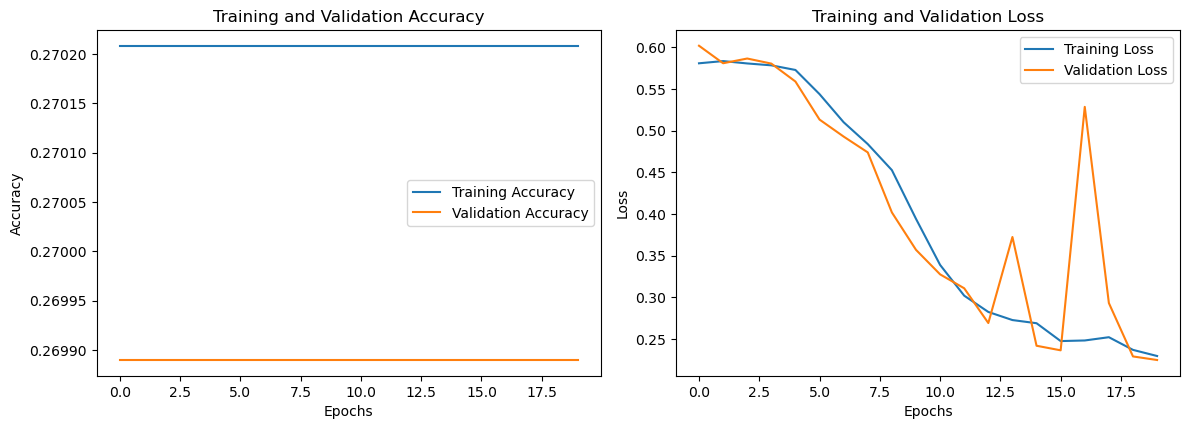

In [38]:
# Plotting function

def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [39]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2622 - auc: 0.5000 - loss: 0.2238
Test Loss: 0.22463379800319672
Test Accuracy: 0.26988983154296875
Test AUC: 0.5


## Quantum neural network

In [41]:
class HybridModel(tf.keras.Model):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_1 = tf.keras.layers.Dense(6, activation='relu', dtype=tf.float64)
        self.classical_nn_2 = tf.keras.layers.Dense(1, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_1(quantum_outputs)
        nn_output = self.classical_nn_2(nn_output)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        # Replace NaNs in trainable variables
        for var in self.trainable_variables:
            # Replace NaNs with zeros
            var.assign(tf.where(tf.math.is_nan(var), tf.zeros_like(var), var))

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Collect metrics
        metrics = {}
        for m in self.metrics:
            result = m.result()
            if isinstance(result, dict):
                # Flatten the dictionary
                for key, value in result.items():
                    metrics[f"{key}"] = value
            else:
                metrics[m.name] = result

        return metrics


In [43]:
model = HybridModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
class DebugCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pass
        # print(logs)
# Start training
history = model.fit(
    train_images, train_labels,
    epochs=25,
    batch_size=32,
    verbose=1,
    validation_data=(validation_images, validation_labels),
    callbacks=[DebugCallback()]
)

Epoch 1/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 96s 383ms/step - accuracy: 0.7362 - auc_2: 0.5070 - loss: 0.3001 - val_accuracy: 0.7301 - val_auc_2: 0.5742 - val_loss: 0.5833
Epoch 2/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 59s 286ms/step - accuracy: 0.7248 - auc_2: 0.4921 - loss: 0.2862 - val_accuracy: 0.7301 - val_auc_2: 0.6818 - val_loss: 0.5653
Epoch 3/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 59s 286ms/step - accuracy: 0.7214 - auc_2: 0.6250 - loss: 0.2760 - val_accuracy: 0.7301 - val_auc_2: 0.7073 - val_loss: 0.5422
Epoch 4/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 59s 288ms/step - accuracy: 0.7383 - auc_2: 0.6795 - loss: 0.2542 - val_accuracy: 0.7038 - val_auc_2: 0.7350 - val_loss: 0.5019
Epoch 5/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 61s 295ms/step - accuracy: 0.7271 - auc_2: 0.7289 - loss: 0.2658 - val_accuracy: 0.7497 - val_auc_2: 0.7937 - val_loss: 0.4810
Epoch 6/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 60s 292ms/step - accuracy: 0.7632 - auc_2: 0.8049 - loss: 0.2669 - val_accuracy: 0.7301 - val_auc_2: 0.7705 - val_loss: 0.814

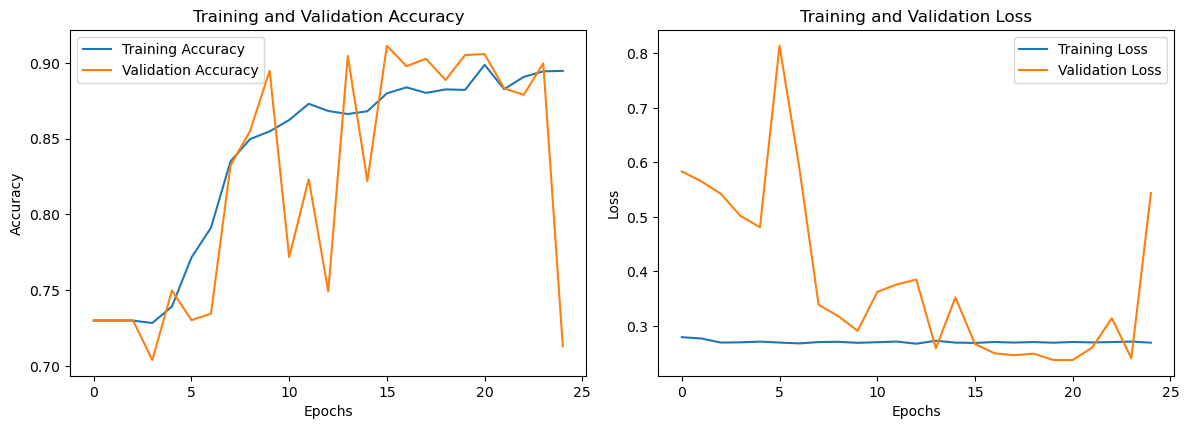

In [44]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)
# print(history.history['accuracy'])

In [45]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7152 - auc_2: 0.9645 - loss: 0.5360
Test Loss: 0.5435617566108704
Test Accuracy: 0.7129743099212646
Test AUC: 0.962193489074707


## Quantum Patch-wise Transformer

In [46]:
class QuantumSelfAttentionHead(Layer):
    def __init__(self, d_model):
        super(QuantumSelfAttentionHead, self).__init__()
        self.d_model = d_model
        self.n_qubits = d_model  # Number of qubits equals the model dimension

        # Define the quantum device
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

        # Initialize quantum weights
        self.quantum_weights = self.add_weight(
            shape=(self.d_model * (self.d_model - 1) // 2,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32,
            name='quantum_weights'
        )

        # Define the quantum circuit as a QNode
        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(self.n_qubits))
            pyramid_circuit(weights, wires=range(self.n_qubits))
            # Return expectation values as float64 (default)
            return [qml.expval(qml.PauliZ(wire)) for wire in range(self.n_qubits)]

        self.quantum_circuit = quantum_circuit

    def call(self, patches):
        """
        Processes each patch through the quantum circuit.

        Args:
            patches (Tensor): Tensor of shape (batch_size, num_patches, d_model).

        Returns:
            Tensor: New patch embeddings after quantum processing, shape (batch_size, num_patches, d_model).
        """
        # Reshape patches to (batch_size * num_patches, d_model)
        batch_size = tf.shape(patches)[0]
        num_patches = tf.shape(patches)[1]
        patch_dim = tf.shape(patches)[2]
        patches_reshaped = tf.reshape(patches, (-1, patch_dim))  # Shape: (batch_size * num_patches, d_model)

        # Ensure the patch_dim matches the number of qubits
        assert_op = tf.debugging.assert_equal(
            patch_dim, self.n_qubits,
            message=f"Patch dimension ({patch_dim}) must equal number of qubits ({self.n_qubits})"
        )
        with tf.control_dependencies([assert_op]):
            # Apply the quantum circuit to each patch
            quantum_outputs = tf.map_fn(
                lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
                patches_reshaped,
                fn_output_signature=tf.TensorSpec(shape=(self.n_qubits,), dtype=tf.float64)
            )

        # Reshape back to (batch_size, num_patches, d_model)
        quantum_outputs = tf.reshape(quantum_outputs, (batch_size, num_patches, self.d_model))

        return quantum_outputs  # No additional projection needed

In [47]:
class QuantumAttentionHead(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(QuantumAttentionHead, self).__init__()
        self.d_model = d_model
        # Initialize quantum weights
        self.quantum_weights = self.add_weight(
            shape=(self.d_model * (self.d_model - 1) // 2,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float64,
            name='quantum_weights'
        )
        # Define the quantum device
        self.dev = qml.device("default.qubit", wires=self.d_model)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_model_pyramid(q, k, weights):
            q = tf.cast(q, tf.float64)
            k = tf.cast(k, tf.float64)
            weights = tf.cast(weights, tf.float64)
            vector_loader(convert_array(q), wires=range(self.d_model))
            pyramid_circuit(weights, wires=range(self.d_model))
            vector_loader(convert_array(k), wires=range(self.d_model), is_x=False, is_conjugate=True)
            return qml.expval(qml.PauliZ(0))

        self.quantum_model_pyramid = quantum_model_pyramid
        self.dense = Dense(d_model, dtype=tf.float64)

    def call(self, queries, keys, values):
        queries = tf.cast(queries, tf.float64)
        keys = tf.cast(keys, tf.float64)
        values = tf.cast(values, tf.float64)

        # Use tf.map_fn to compute attention scores without broadcasting
        def compute_attention_scores_per_batch(batch_queries_keys_values):
            batch_queries, batch_keys, batch_values = batch_queries_keys_values
            num_queries = tf.shape(batch_queries)[0]

            def compute_attention_per_query(query):
                def compute_score(key):
                    return self.quantum_model_pyramid(query, key, self.quantum_weights)
                attention_scores = tf.map_fn(compute_score, batch_keys, dtype=tf.float64)
                return attention_scores

            attention_scores = tf.map_fn(compute_attention_per_query, batch_queries, dtype=tf.float64)
            # Apply softmax
            attention_weights = tf.nn.softmax(attention_scores, axis=-1)
            # Compute weighted sum over values
            weighted_values = tf.matmul(attention_weights, batch_values)
            # Pass through the final Dense layer
            final_output = self.dense(weighted_values)
            return final_output, attention_weights

        outputs = tf.map_fn(
            compute_attention_scores_per_batch,
            (queries, keys, values),
            dtype=(tf.float64, tf.float64)
        )
        final_output, attention_weights = outputs
        return final_output, attention_weights


In [48]:
class Block(Layer):
    def __init__(self, projection_dim, dropout_rate=0.1):
        """
        Initializes the Transformer Block with Quantum Self-Attention.

        Args:
            projection_dim (int): Dimension of the projection (should match d_model).
            dropout_rate (float): Dropout rate to apply after layers.
        """
        super(Block, self).__init__()
        # First layer normalization (float64)
        self.norm1 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        # Quantum Self-Attention Head
        self.attn = QuantumSelfAttentionHead(d_model=projection_dim)
        # Second layer normalization (float64)
        self.norm2 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        """
        Forward pass for the Transformer Block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_patches + 1, projection_dim).

        Returns:
            Tensor: Output tensor of the same shape as input.
        """
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply Quantum Self-Attention
        attention_output = self.attn(x1)
        # Add residual connection
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection
        y = Add()([x3, x2])
        return y

In [49]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

In [50]:
# Define the QuantumSelfAttentionVisionTransformer class with the updated train_step needed to handle nan values
class QuantumSelfAttentionVisionTransformer(tf.keras.Model):
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Collect metrics
        metrics = {}
        for m in self.metrics:
            result = m.result()
            if isinstance(result, dict):
                # Flatten the dictionary
                for key, value in result.items():
                    metrics[f"{key}"] = value
            else:
                metrics[m.name] = result

        return metrics

In [51]:
def create_QuantumSelfAttention_VisionTransformer(num_classes, num_patches=324, projection_dim=6, input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='sigmoid')(representation)
    # Create custom model
    model = QuantumSelfAttentionVisionTransformer(inputs, logits)
    return model

model = create_QuantumSelfAttention_VisionTransformer(1)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: (<gast.gast.NamedExpr object at 0x73a7da6f3610>, (meas := op.hyperparameters['measurement']))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x73a882ea7d80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "quantum_self_attention_vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extractor_3               │ (None, 324, 49)        │             0 │
│ (PatchExtractor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_2 (PatchEncoder)  │ (None, 325, 6)         │         2,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 325, 6)         │           213 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 6)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,470 (9.74 KB)

 Trainable params: 2,470 (9.74 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=25,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/25


W0000 00:00:1731565628.008325  811614 assert_op.cc:38] Ignoring Assert operator quantum_self_attention_vision_transformer_1/transformer_encoder_2_1/block_3_1/quantum_self_attention_head_1/assert_equal_1/Assert/Assert


204/205 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.5683 - auc: 0.4313 - loss: 0.4612

W0000 00:00:1731571406.049830  811613 assert_op.cc:38] Ignoring Assert operator quantum_self_attention_vision_transformer_1/transformer_encoder_2_1/block_3_1/quantum_self_attention_head_1/assert_equal_1/Assert/Assert


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.5687 - auc: 0.4314 - loss: 0.4610 

W0000 00:00:1731571428.016637  811611 assert_op.cc:38] Ignoring Assert operator quantum_self_attention_vision_transformer_1/transformer_encoder_2_1/block_3_1/quantum_self_attention_head_1/assert_equal_1/Assert/Assert
W0000 00:00:1731571865.105593  811615 assert_op.cc:38] Ignoring Assert operator quantum_self_attention_vision_transformer_1/transformer_encoder_2_1/block_3_1/quantum_self_attention_head_1/assert_equal_1/Assert/Assert


205/205 ━━━━━━━━━━━━━━━━━━━━ 6258s 30s/step - accuracy: 0.5692 - auc: 0.4316 - loss: 0.4608 - val_accuracy: 0.7301 - val_auc: 0.4499 - val_loss: 0.5965
Epoch 2/25
 17/205 ━━━━━━━━━━━━━━━━━━━━ 1:33:23 30s/step - accuracy: 0.7007 - auc: 0.4355 - loss: 0.3485

In [ ]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

## Quantum Transformer

In [ ]:
class QuantumAttentionHead(Layer):
    def __init__(self, d_model):
        super(QuantumAttentionHead, self).__init__()
        self.d_model = d_model

        # Initialize quantum weights for the quantum circuit
        self.quantum_weights = self.add_weight(
            shape=(self.d_model * (self.d_model - 1) // 2,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float64,
            name='quantum_weights'
        )

        # Define the quantum device
        self.dev = qml.device("default.qubit", wires=self.d_model)

        # Define the quantum circuit as a QNode
        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_model_pyramid(q, k, weights):
            q = tf.cast(q, tf.float64)
            k = tf.cast(k, tf.float64)
            weights = tf.cast(weights, tf.float64)
            vector_loader(convert_array(q), wires=range(self.d_model))
            pyramid_circuit(weights, wires=range(self.d_model))
            vector_loader(convert_array(k), wires=range(self.d_model), is_x=False, is_conjugate=True)
            return qml.expval(qml.PauliZ(0))

        self.quantum_model_pyramid = quantum_model_pyramid

        # Define the final Dense layer to project the attention output
        self.dense = Dense(d_model, dtype=tf.float64)
    @tf.function(jit_compile=False)
    def call(self, queries, keys, values):
        """
        Forward pass for the Quantum Attention Head.

        Args:
            queries (Tensor): Shape (batch_size, num_queries, d_model)
            keys (Tensor): Shape (batch_size, num_keys, d_model)
            values (Tensor): Shape (batch_size, num_keys, d_model)

        Returns:
            Tuple[Tensor, Tensor]:
                - Output tensor after applying quantum attention and projection, shape (batch_size, num_queries, d_model)
                - Attention weights tensor, shape (batch_size, num_queries, num_keys)
        """
        # Ensure all inputs are float64
        queries = tf.cast(queries, tf.float64)
        keys = tf.cast(keys, tf.float64)
        values = tf.cast(values, tf.float64)

        # Get dynamic shapes as tensors
        batch_size = tf.shape(queries)[0]
        num_queries = tf.shape(queries)[1]
        num_keys = tf.shape(keys)[1]
        d_model = tf.shape(queries)[2]

        # Cast all shape components to tf.int32
        batch_size = tf.cast(batch_size, tf.int32)
        num_queries = tf.cast(num_queries, tf.int32)
        num_keys = tf.cast(num_keys, tf.int32)
        d_model = tf.cast(d_model, tf.int32)

        # Expand dimensions
        queries_expanded = tf.expand_dims(queries, axis=2)
        keys_expanded = tf.expand_dims(keys, axis=1)

        # Create shapes as tensors
        target_shape = tf.stack([batch_size, num_queries, num_keys, d_model])

        # Broadcast tensors
        queries_broadcast = tf.broadcast_to(queries_expanded, target_shape)
        keys_broadcast = tf.broadcast_to(keys_expanded, target_shape)

        # Stack queries and keys for mapping
        # stacked_inputs: (batch_size, num_queries, num_keys, 2, d_model)
        stacked_inputs = tf.stack([queries_broadcast, keys_broadcast], axis=-2)

        # Reshape to (batch_size * num_queries * num_keys, 2, d_model) for vectorized_map
        stacked_inputs_reshaped = tf.reshape(stacked_inputs, [batch_size * num_queries * num_keys, 2, d_model])

        # Compute attention scores using the quantum circuit
        def compute_attention_score(inputs):
            q, k = tf.unstack(inputs, num=2, axis=0)  # Each of shape (d_model,)
            return self.quantum_model_pyramid(q, k, self.quantum_weights)  # Returns a scalar

        # Vectorize the computation over all query-key pairs
        attention_scores = tf.map_fn(
            compute_attention_score,
            stacked_inputs_reshaped
        )  # Shape: (batch_size * num_queries * num_keys,)

        # Reshape back to (batch_size, num_queries, num_keys)
        attention_scores = tf.reshape(attention_scores, [batch_size, num_queries, num_keys])

        # Apply softmax to obtain attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)  # Shape: (batch_size, num_queries, num_keys)

        # Multiply attention weights with values
        # values: (batch_size, num_keys, d_model)
        # attention_weights: (batch_size, num_queries, num_keys)
        # Need to perform batched matrix multiplication
        weighted_values = tf.matmul(attention_weights, values)  # Shape: (batch_size, num_queries, d_model)

        # Pass through the final Dense layer
        final_output = self.dense(weighted_values)  # Shape: (batch_size, num_queries, d_model)

        return final_output, attention_weights

In [ ]:
class Block(Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        self.attn = QuantumAttentionHead(d_model=d_model)
        self.norm2 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        self.mlp = MLP(hidden_features=d_model * 2, out_features=d_model, dropout_rate=dropout_rate)
    @tf.function(jit_compile=False)
    def call(self, x):
        # x shape: (batch_size, num_patches, d_model)
        # Normalize the input
        x_norm = self.norm1(x)
        # Apply Quantum Attention
        attn_output, attn_weights = self.attn(x_norm, x_norm, x_norm)  #(q, k, v) = (x_norm, x_norm, x_norm)
        # Residual connection
        x = Add()([attn_output, x])
        # Second normalization
        x_norm = self.norm2(x)
        # Apply MLP
        mlp_output = self.mlp(x_norm)
        # Second residual connection
        x = Add()([mlp_output, x])
        return x

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)
    @tf.function(jit_compile=False)
    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

In [ ]:
# Define the QuantumVisionTransformer class with the updated train_step needed to handle nan values
class QuantumVisionTransformer(tf.keras.Model):
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [ ]:
# import os
# import numpy as np
# from PIL import Image
# from sklearn.model_selection import train_test_split

# # Constants
# SOI_PATH = '/home/HardDisk/yared/spectrogram-dataset/soi'
# CWI_PATH = '/home/HardDisk/yared/spectrogram-dataset/cwi'
# IMAGE_SIZE = (128, 128)

# # Preprocessing and resizing function
# def preprocess_image(img_path, image_size=IMAGE_SIZE):
#     img = Image.open(img_path)
#     img = img.convert('L')  # Convert to grayscale
#     img = img.resize(image_size)
#     img_array = np.array(img)  # Convert to numpy array
#     img_array = img_array.astype(np.float32)  # Convert to float32 for better precision
#     img_array = img_array / 255.0  # Normalize to [0, 1]
#     return img_array

# def load_images(folder_path, label):
#     images = []
#     labels = []
#     for filename in os.listdir(folder_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             img_path = os.path.join(folder_path, filename)
#             img_array = preprocess_image(img_path)
#             images.append(img_array)
#             labels.append(label)
#     return images, labels

# # Load images and labels
# soi_images, soi_labels = load_images(SOI_PATH, 0)
# cwi_images, cwi_labels = load_images(CWI_PATH, 1)

# # Combine images and labels
# X = np.array(soi_images + cwi_images)
# y = np.array(soi_labels + cwi_labels)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Example output shapes
# print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
# print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


In [ ]:
def create_QuantumVisionTransformer(num_classes, num_patches=324, projection_dim=6, input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape, batch_size=32)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='sigmoid')(representation)
    # Create custom model
    model = QuantumVisionTransformer(inputs, logits)
    return model

model = create_QuantumVisionTransformer(1)
model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [ ]:
train_images = train_images.astype(np.float32)
validation_images = validation_images.astype(np.float32)
train_labels = train_labels.astype(np.int32)
validation_labels = validation_labels.astype(np.int32)


In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=25,
    batch_size=2,
    validation_data=(validation_images, validation_labels)
)

In [ ]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")